# DeepSensor Quickstart

This notebook demonstrates how to use DeepSensor to train a ConvNP model to spatially interpolate ERA5 air temperature data over North America and use the trained model predict air temperature at arbitrary locations.

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# import deepsensor.tensorflow
import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.train.train import train_epoch

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
from deepsensor.train.train import set_gpu_default_device

set_gpu_default_device()

In [4]:
# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


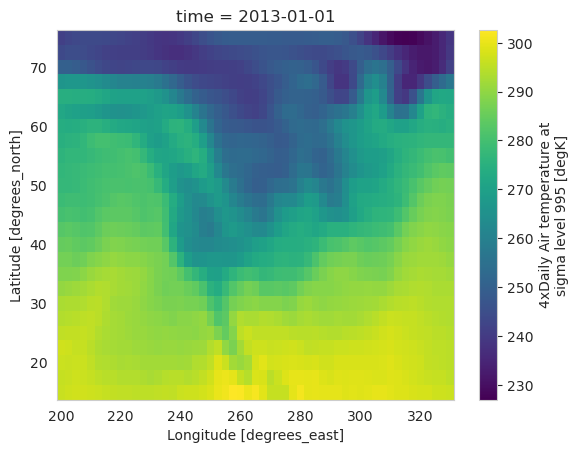

In [5]:
print(ds_raw)
ds_raw.isel(time=0).air.plot()

In [6]:
# Normalise data
data_processor = DataProcessor(x1_name="lat", x1_map=(ds_raw["lat"].min(), ds_raw["lat"].max()), x2_name="lon", x2_map=(ds_raw["lon"].min(), ds_raw["lon"].max()))
ds = data_processor(ds_raw)

In [7]:
from deepsensor.data.utils import construct_x1x2_ds

x1x2_ds = construct_x1x2_ds(ds)
ds['x1_arr'] = x1x2_ds['x1_arr']
ds['x2_arr'] = x1x2_ds['x2_arr']
aux_ds = ds[['x1_arr', 'x2_arr']]
ds = ds[['air']]

In [8]:
# Set up task loader
task_loader = TaskLoader(context=ds, target=ds)

In [9]:
# Set up model
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*8)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 39
encoder_scales inferred from TaskLoader: [0.015224358066916466]
decoder_scale inferred from TaskLoader: 0.02564102564102564


In [10]:
# Generate training tasks with up to 10% of grid cells passed as context and all grid cells
# passed as targets
train_tasks = []
for date in pd.date_range("2013-01-01", "2014-11-30")[::7]:
    task = task_loader(date, context_sampling=np.random.uniform(0.0, 0.1), target_sampling="all")
    train_tasks.append(task)

In [11]:
from tqdm import tqdm

# Train model
n_epochs = 1
for epoch in tqdm(range(n_epochs)):
    losses = train_epoch(model, train_tasks)

100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.16s/it]


In [12]:
# Predict on new task with 40 random grid cells passed as context
test_task = task_loader("2014-12-31", 40)
mean_ds, std_ds = model.predict(test_task, X_t=ds_raw)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 285.3 285.3 285.3 ... 293.2 292.4 291.7


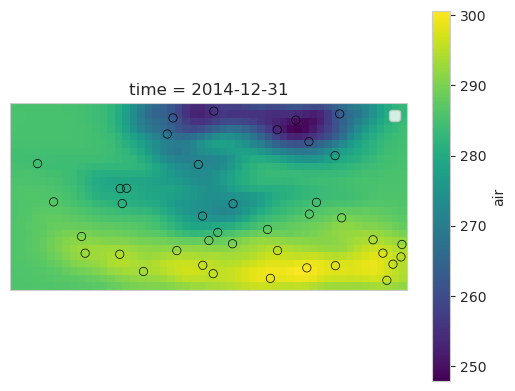

In [13]:
print(mean_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
mean_ds.isel(time=0).air.plot(ax=ax)
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 10.88 10.89 10.89 ... 7.898 8.135 8.346


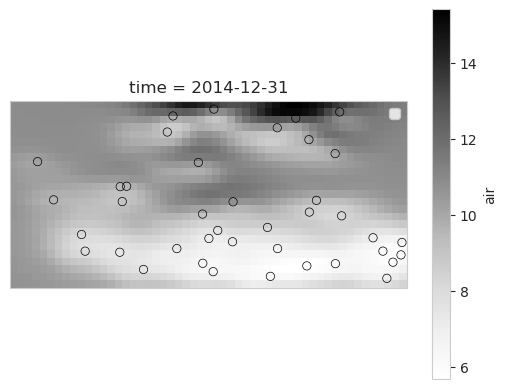

In [14]:
print(std_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
std_ds.isel(time=0).air.plot(cmap='Greys')
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

In [15]:
# Predict at New York, San Francisco, and Seattle with 40 random (fixed) context points
X_t = np.array([[40.7128, 360-74.0060], [37.7749, 360-122.4194], [47.6062, 360-122.3321]]).T
test_tasks = task_loader(pd.date_range("2014-12-01", "2014-12-31"), 40, seed_override=42)

In [16]:
mean_df, std_df = model.predict(test_tasks, X_t=X_t, append_indexes={"loc": ["new_york", "san_francisco", "seattle"]})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


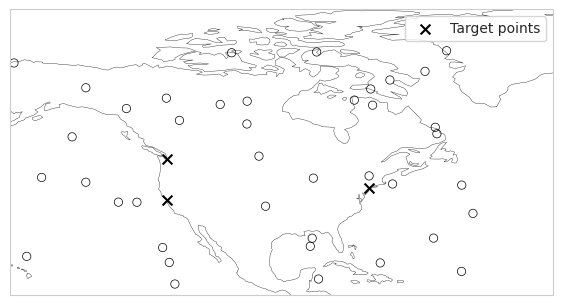

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.set_extent([ds_raw["lon"].min(), ds_raw["lon"].max(), ds_raw["lat"].min(), ds_raw["lat"].max()])
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader, linewidths=0.5)
ax.scatter(X_t[1, :], X_t[0, :], marker="x", color="black", s=50, label="Target points")
ax.legend()
plt.show()

/tmp/ipykernel_11647/3059797121.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


                                                  air
time       lat     lon      loc                      
2014-12-01 40.7128 285.9940 new_york       284.711705
           37.7749 237.5806 san_francisco  289.285381
           47.6062 237.6679 seattle        283.711302
2014-12-02 40.7128 285.9940 new_york       281.546603
           37.7749 237.5806 san_francisco  289.093709
...                                               ...
2014-12-30 37.7749 237.5806 san_francisco  287.915763
           47.6062 237.6679 seattle        283.407036
2014-12-31 40.7128 285.9940 new_york       275.097124
           37.7749 237.5806 san_francisco  287.379619
           47.6062 237.6679 seattle        284.184726

[93 rows x 1 columns]


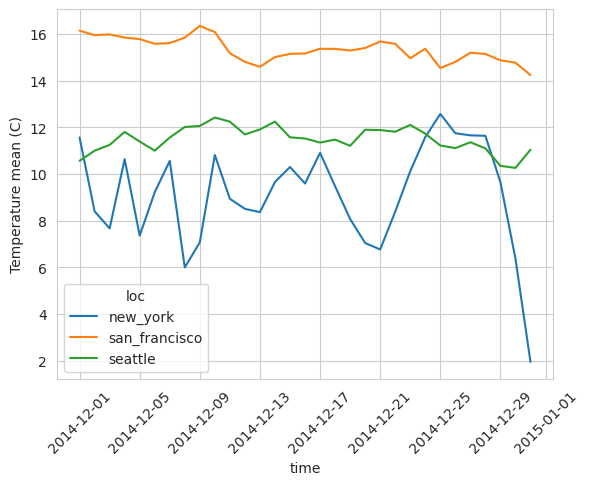

In [18]:
print(mean_df)
ax = sns.lineplot(data=mean_df-273.15, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature mean (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

                                                 air
time       lat     lon      loc                     
2014-12-01 40.7128 285.9940 new_york          9.1009
           37.7749 237.5806 san_francisco   8.878046
           47.6062 237.6679 seattle         9.823362
2014-12-02 40.7128 285.9940 new_york        9.095055
           37.7749 237.5806 san_francisco   8.831662
...                                              ...
2014-12-30 37.7749 237.5806 san_francisco   9.314838
           47.6062 237.6679 seattle         9.830656
2014-12-31 40.7128 285.9940 new_york        9.264377
           37.7749 237.5806 san_francisco   9.391305
           47.6062 237.6679 seattle        10.143012

[93 rows x 1 columns]


/tmp/ipykernel_11647/819664832.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


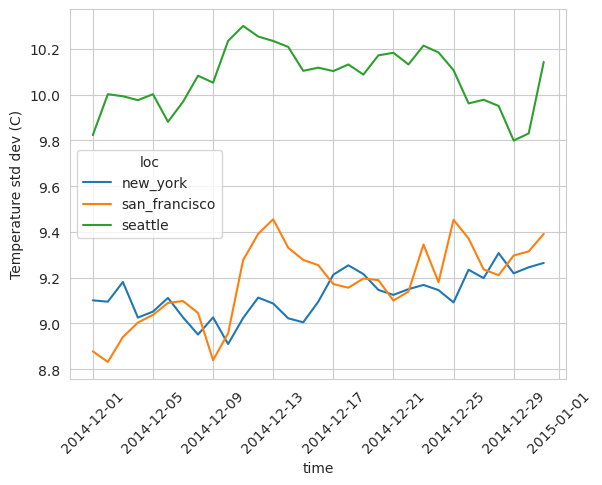

In [19]:
print(std_df)
ax = sns.lineplot(data=std_df, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature std dev (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)